In [260]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

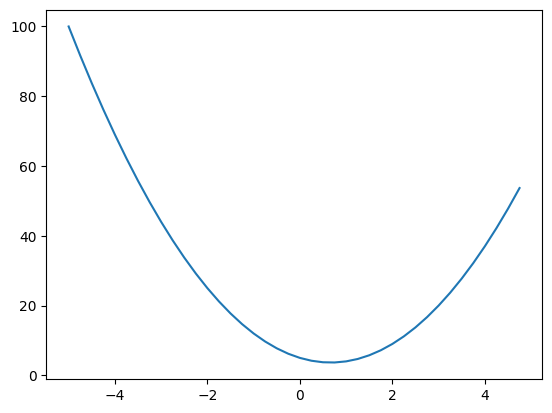

In [6]:
x5 = np.arange(-5,5,0.25)
y5 = f(x5)
plt.plot(x5,y5)

In [7]:
# deravative
h = 0.000001
x = 2/3  
(f(x+h) - f(x))/h

2.999378523327323e-06

In [8]:
# lets gets more complex

a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [9]:
h= 0.0001

# inputs 
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
c += h
d2 = a*b+c

print("d1", d1)
print("d2", d2)

print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


data structure for handling values

In [20]:
class Value:
    def __init__(self,data,_children = (), _op = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), "+")
        return out
    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other), "*")
        return out
    
    
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c
#(a.__mul__(b)).__add__(c)


In [26]:
d._prev,d._op

({Value(data=-6.0), Value(data=10.0)}, '+')

In [295]:
class Value:
    def __init__(self,data,_children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other  # other * self
    def __radd__(self, other):
        return self + other # other + self
    
    def __truediv__(self,other):
        return self * other**-1 # self / other
    
    def __neg__(self): # -self
        return self * -1
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t,(self,), 'tanh')
        
        def _backward():
            self.grad += (1.0 - t**2 )* out.grad
            
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
    
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
    
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f ; L.label = "L"
L,L.label


(Value(data=-8.0), 'L')

function for visulizing the data structure



In [63]:
from graphviz import Digraph

def trace(root):
    # builds a set of nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir':"LR"}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph , create a rectangular ('record') note for it
        dot.node(name = uid, label= "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            #if this value is a result of some operation , create a op node for it
            dot.node(name = uid+ n._op,label = n._op)
            # and connet this node to it
            dot.edge(uid + n._op , uid)
            
    for n1,n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

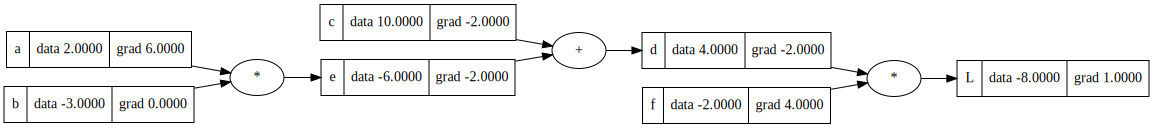

In [129]:
draw_dot(L)

In [68]:
"""L = d * f

dL/dd = ? f

(f(x+h) - f(x)) /h
((d+h)*f - d*f)/h
(d*f + f*h - d*f) /h
f*h / h
f"""

'L = d * f\n\ndL/dd = ? f\n\n(f(x+h) - f(x)) /h\n((d+h)*f - d*f)/h\n(d*f + f*h - d*f) /h\nf*h / h\nf'

In [125]:
L.grad = 1.0


In [126]:
f.grad = 4.0
d.grad = -2.0

In [127]:
c.grad = -2.0
e.grad = -2.0

In [128]:
a.grad = -3.0 * -2.0
b.grad = 2.0 * -2.0

In [102]:
def lol():
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')

    e = a*b; e.label = 'e'
    d = e + c ; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f ; L.label = "L"
    L1 = L.data
    
    h = 0.001
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    b.data +=h
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 , label = 'f')
    L = d * f ; L.label = "L"
    L2 = L.data
    
    print((L2 - L1)/h)
    
    
    
lol()

-3.9999999999995595


In [103]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d * f

print(L.data)


-7.286496


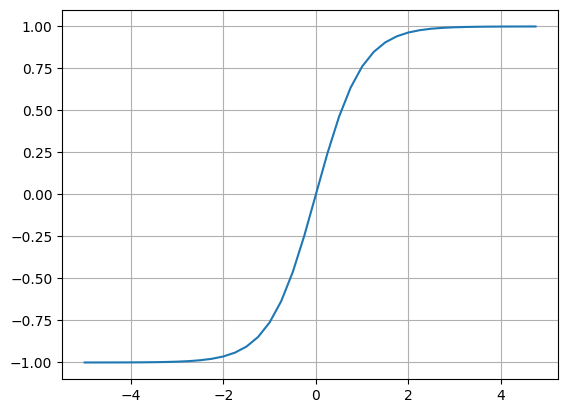

In [107]:
# tanh activation function

plt.plot(np.arange(-5,5,0.25), np.tanh(np.arange(-5,5,0.25)))
plt.grid()

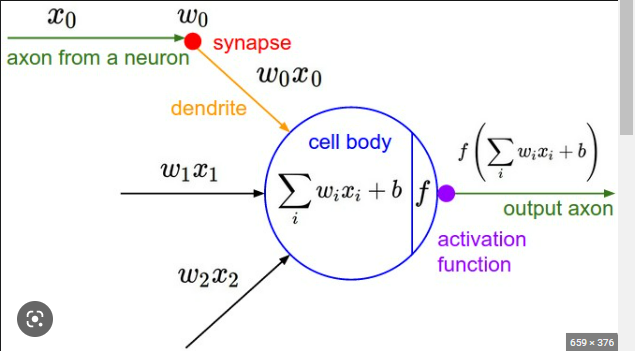

In [199]:
# inputs 
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = "x2")

# weights w1 , w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = 'w2')

# bias for neuron 
b = Value(6.8813735870195432, label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1 ; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh(); o.label = 'o'


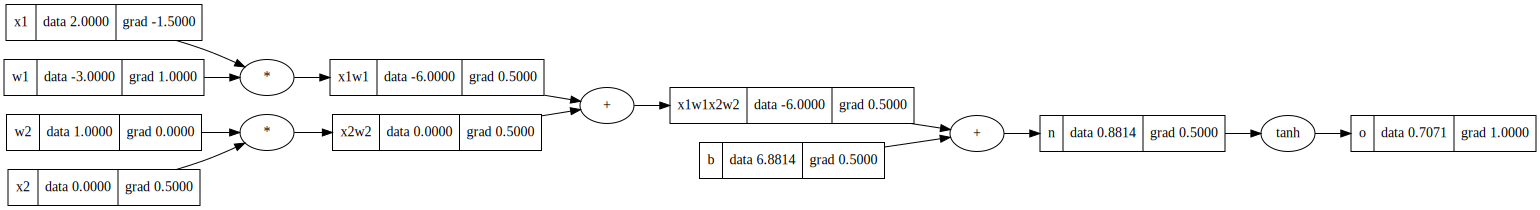

In [202]:
draw_dot(o)

In [201]:
o.backward()

In [181]:
o.grad = 1.0 # base case

In [153]:
o._backward()

In [156]:
n._backward()

In [158]:
b._backward()

In [160]:
x1w1x2w2._backward()

In [162]:
x1w1._backward()

In [163]:
x2w2._backward()

In [154]:
#o  = tanh(h)
# do/dn = 1 - o **2

In [138]:
n.grad = 0.5

In [140]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [142]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [144]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad


In [146]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

bug in back propagation

- to fix the issue with the backpropagation we have to accumulate the gradients i.e instead of setting the gradients ,  increament the gradients(+=)

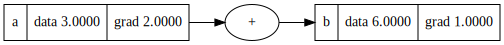

In [203]:
a = Value(3.0, label = 'a')
b = a+a ; b.label = 'b'

b.backward()
draw_dot(b)

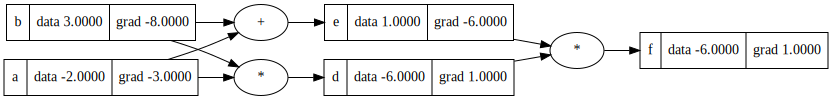

In [205]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b ; d.label = "d"
e = a + b; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()
draw_dot(f)

In [209]:
a = Value(2.0)
a+2

Value(data=4.0)

In [213]:
a * 10

Value(data=20.0)

In [215]:
3 * a

Value(data=6.0)

In [229]:
a.exp()

Value(data=7.38905609893065)

In [237]:
a = Value(10.0)
b = Value(20.0)

a/b


Value(data=0.5)

In [239]:
b -a

Value(data=10.0)

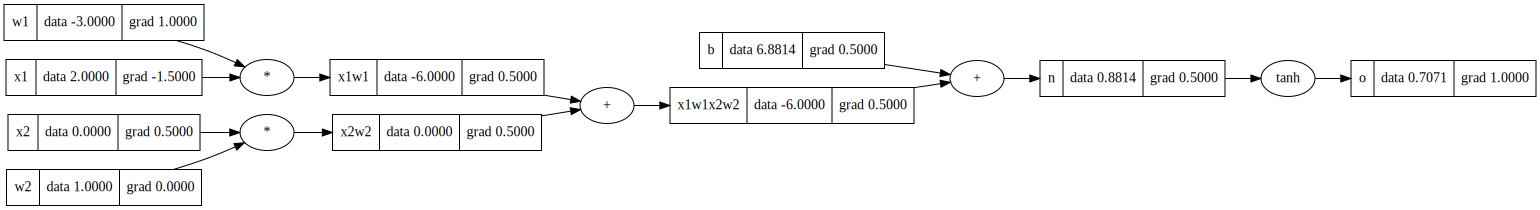

In [240]:
# inputs 
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = "x2")

# weights w1 , w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = 'w2')

# bias for neuron 
b = Value(6.8813735870195432, label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1 ; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

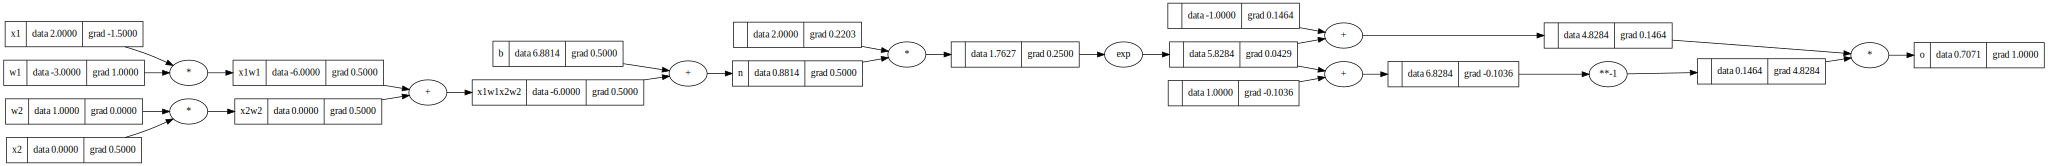

In [241]:
# inputs 
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = "x2")

# weights w1 , w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = 'w2')

# bias for neuron 
b = Value(6.8813735870195432, label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1 ; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b ; n.label = 'n'
# --- 
e = (2*n).exp()
o = (e - 1) / (e + 1)

# ----
o.label = 'o'
o.backward()
draw_dot(o)

## Doing the same network as above in pytorch

In [244]:
import torch

In [248]:

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('x2', x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
-----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [251]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [253]:
o.item() # o.data.item() and o.item() produces same result

0.7071066904050358

In [256]:
x2.grad

tensor([0.5000], dtype=torch.float64)

## Implementing this Neural Network

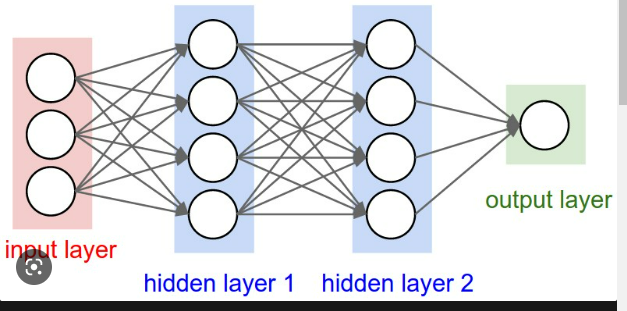



In [313]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer: 
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    


In [369]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.6443995160760466)

In [316]:
len(n.parameters())

41

In [370]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0,-1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [356]:
# mean squared loss
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # ygt = ground truth
loss  #forward pass

Value(data=3.3633495261871425e-05)

In [357]:
for p in n.parameters():
    p.grad = 0.0 # setting the grad to 0
loss.backward() # backward pass

In [358]:
for p in n.parameters():
    p.data += -0.01 * p.grad  # update gradient

In [359]:
ypred

[Value(data=0.9967371401069476),
 Value(data=-0.9988107260574344),
 Value(data=-0.9978300173718029),
 Value(data=0.9958934146224584)]

In [360]:
n.layers[0].neurons[0].w[0].grad

-0.23094011760549438

In [385]:
# reinitializing the network and do all the turnning in loops

for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update gradient
    for p in n.parameters():
        p.data += -0.1 * p.grad
        
    print(k, loss.data)
    

0 0.0031193438033652356
1 0.0030925713286026613
2 0.0030662409819426292
3 0.0030403420409555243
4 0.0030148641246405365
5 0.002989797180006239
6 0.002965131469277186
7 0.0029408575576926966
8 0.0029169663018662395
9 0.0028934488386754866
10 0.0028702965746554066
11 0.0028475011758677215
12 0.002825054558222343
13 0.0028029488782272335
14 0.0027811765241449837
15 0.0027597301075352656
16 0.0027386024551638456
17 0.002717786601259694
18 0.0026972757801030102
19 0.0026770634189276703


In [386]:
ypred

[Value(data=0.97582095118029),
 Value(data=-0.980131556399701),
 Value(data=-0.9719489616931395),
 Value(data=0.9698201852903214)]